In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np
import os

from tqdm import tqdm, trange

import sys
sys.path.append('../utilities')

import to_utils
import models_torch

Load the data. If the following errors out, please check that you have downloaded the TO datasets. Note that this notebook loads the entire data into memory. If memory limited, this notebook may have to be modified. 

In [2]:
P, N_real, N_procedural, N_rejected = to_utils.load_data("../TO_Datasets/")

You can select to use the procedurally-generated negative data or rejection-sampled negative data.

In [3]:
#select synthetic or rejection sampled negative data to add to the few real negatives

N = torch.cat((N_real, N_procedural), 0)
# N = torch.cat((N_real, N_rejected), 0)

We'll make sure all the positive data and negative data are, in fact, positive and negative respectively:

In [4]:
validity, _ = to_utils.eval_batch_validity(N.detach().numpy())
assert np.all(validity == False)

validity, _ = to_utils.eval_batch_validity(P.detach().numpy())
assert np.all(validity == True)


Perform data augmentations on the data (optional, but used in the paper):

In [5]:
#use all four rotations and two flips to augment the data 

P = to_utils.augment_all(P)
N = to_utils.augment_all(N)

Preprocess:

In [6]:
P = P.unsqueeze(1)
N = N.unsqueeze(1)
P = P.type(torch.float32)/255*2-1
N = N.type(torch.float32)/255*2-1

P = P[torch.randperm(P.shape[0])]
N = N[torch.randperm(N.shape[0])]

Select a train step function (GAN, GAN-DO or GAN-MDD):

In [7]:
from models_torch import GAN_step_MDD, GAN_step_DO, GAN_step_vanilla

# train_step_fn = GAN_step_vanilla
# train_step_fn = GAN_step_DO
train_step_fn = GAN_step_MDD

We define some hyperparameters and create the networks:

In [8]:
num_epochs = 1
lr = 0.0002
beta1 = 0.5
image_size = 64
batch_size = 128
nz = 100  # Size of the latent vector
ngf = 64  # Size of feature maps in the generator
ndf = 64  # Size of feature maps in the discriminator

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
netG = to_utils.Generator(nz, ngf).to(device)

if train_step_fn == GAN_step_MDD:
    netD = to_utils.Discriminator(ndf, 3).to(device)
else:
    netD = to_utils.Discriminator(ndf, 1).to(device)

Time to train the model!

In [9]:
from models_torch import train, ReusableDataLoader
from torch.utils.data import TensorDataset

num_steps = num_epochs*len(P)//batch_size

D_opt = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
G_opt = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

def check_refill_pool(pool, length, batch_size):
    if length<batch_size:
        raise Exception("dataset is smaller than batch size!")
    while len(pool)<batch_size:
        remset = set(range(length))-set(pool)
        pool = pool + list(remset)
    return pool

P_loader = ReusableDataLoader(TensorDataset(P), batch_size)
N_loader = ReusableDataLoader(TensorDataset(N), batch_size)

netD, netG, _ = train(netD, netG, None, D_opt, G_opt, None, P_loader, N_loader, num_steps, batch_size, nz, train_step_fn, device, 1, 0)

100%|██████████| 2027/2027 [01:27<00:00, 23.22it/s, L_D_real=0.8531, L_D_neg=0.4148, L_D_fake=0.4770, L_G=3.6209] 


Great! Now lets evaluate 1000 batch of 128 topologies:

In [10]:
all_valid, all_areas, all_diversity = to_utils.evaluate_n_batches(netG, device, nz, 1000, 128)
print("Mean invalidity rate (%):", (1-np.mean(all_valid))*100)
print("Mean violation magnitude (%):", np.mean(all_areas)/64/64*100)
print("Mean diversity:", np.mean(all_diversity))

100%|██████████| 1000/1000 [00:28<00:00, 35.70it/s]

Mean invalidity rate (%): 82.0875
Mean violation magnitude (%): 2.6664209365844727
Mean diversity: 14.421967862455494


We'll plot a few generated images and label them with their validity:

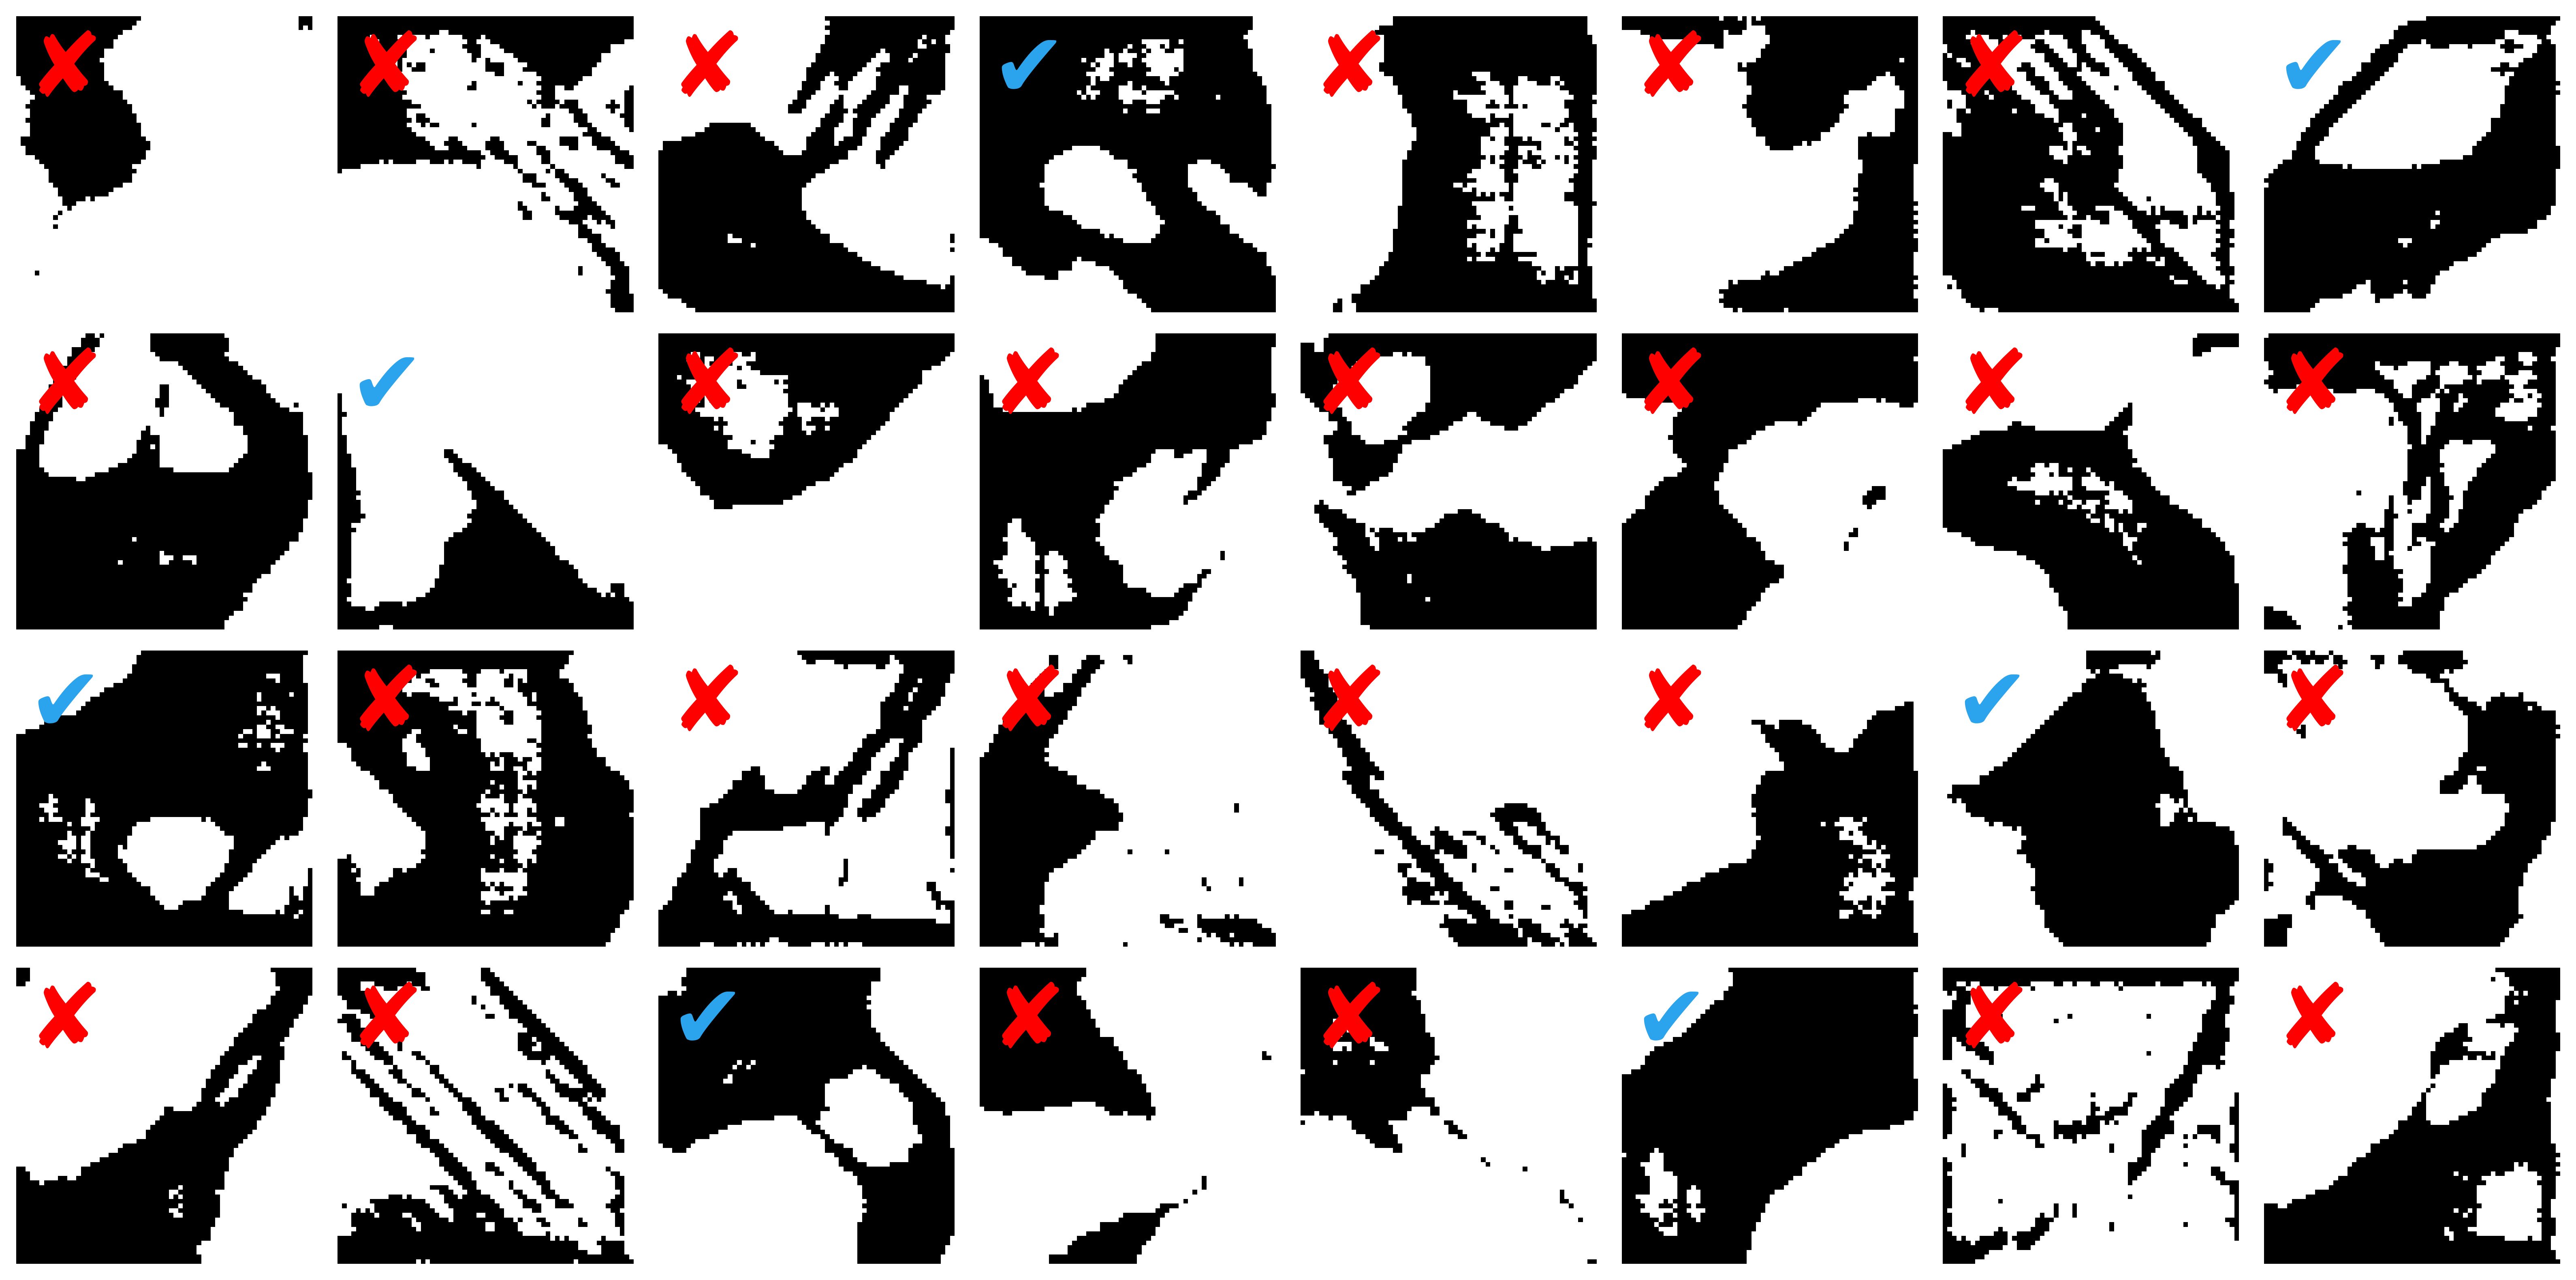

In [11]:
fake = netG(torch.randn(batch_size, nz, 1, 1, device=device)).detach().cpu()
fake = (fake>0)*255
samples=fake.cpu().numpy()[:,0,:,:]
validity, _ = to_utils.eval_batch_validity(samples)
fig, ax = plt.subplots(4, 8, figsize=(16, 8), dpi=400)
for i in range(4):
    for j in range(8):
        idx = i*8+j
        ax[i, j].imshow(samples[idx], cmap='gray')
        ax[i, j].axis('off')
        if validity[idx] == 1:  # Valid sample
            ax[i, j].text(2, 2, '✔', color='#2BA3ED', fontsize=40, 
                        ha='left', va='top', fontweight='bold')
        else:  # Invalid sample
            ax[i, j].text(2, 2, '✘', color='red', fontsize=40, 
                        ha='left', va='top', fontweight='bold')
fig.tight_layout()